Merged data shape: (23374, 3)
Shape of 5-year dataset: (1826, 3)
X shape: (1797, 20, 2) y shape: (1797, 10, 2)


C:\Users\Sedaghat\AppData\Local\Temp\ipykernel_11044\1314167016.py:56: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  today = datetime.utcnow()
C:\Users\Sedaghat\anaconda3\envs\swot-env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.7648
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6237
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4788
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3627
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2830
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2191
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1788
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1647
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1500
Epoch 10/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1442
Predicted x and y for next 10 days:
                                  x         y
2025-12-10 00:00:00+00:00  0.060050  0.263705
2025-12-11 00:00:00+00:00  0.058576  0.265045
2025-12-12 00:00:00+00:00  0.057261  0.266249
2025-12-13 00:00:00+00:00  0.056087  0.267380
2025-12-14 00:00:00+00:00  0.055019  0.268453
2025-12-15 00:00:00+00:00  

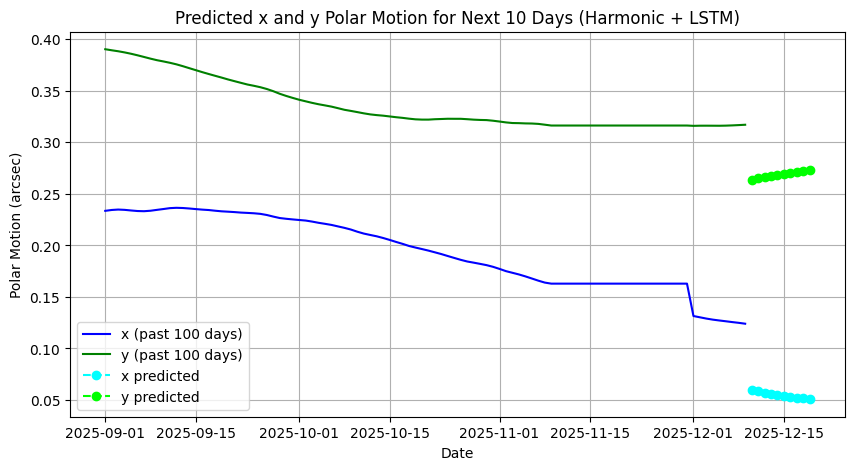

In [2]:
import requests
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import math

# =========================
# --- 1. دانلود و پردازش داده‌ها ---
# --- فایل C04 ---
url_c04 = "https://datacenter.iers.org/data/224/eopc04_14_IAU2000.62-now.txt"
resp = requests.get(url_c04, params={"downloadformat":"txt"})
with open("eop1.txt", "wb") as f: f.write(resp.content)

with open("eop1.txt", "r") as f:
    lines = f.readlines()[14:]  # حذف هدر
c04_data = []
for line in lines:
    try:
        parts = list(map(float, line.strip().split()))
        c04_data.append(parts)
    except:
        continue
c04_data = np.array(c04_data)[:, [3, 4, 5]]  # MJD, x, y

# --- فایل Bulletin ---
url_bu = "https://datacenter.iers.org/data/13/finals2000A.daily"
resp = requests.get(url_bu, params={"downloadformat":"txt"})
with open("bu.txt","wb") as f: f.write(resp.content)

with open("bu.txt","r") as f:
    lines = f.readlines()[14:]
bu_data = []
for line in lines:
    parts = line.strip().split()
    if len(parts)>=7:
        try:
            bu_data.append([float(parts[2]), float(parts[4]), float(parts[6])])  # MJD, x, y
        except:
            continue
bu_data = np.array(bu_data)

# --- ادغام داده‌ها ---
last_c04_mjd = c04_data[-1,0]
bu_new = bu_data[bu_data[:,0] > last_c04_mjd]
all_data = np.vstack([c04_data, bu_new])
print("Merged data shape:", all_data.shape)

# =========================
# --- 2. آماده‌سازی دیتاست ۵ ساله ---
today = datetime.utcnow()
start_date = today - timedelta(days=5*365)  # تقریبی ۵ سال

def date_to_mjd(year, month, day):
    dt = datetime(year, month, day)
    a = (14 - dt.month)//12
    y = dt.year + 4800 - a
    m = dt.month + 12*a - 3
    jd = dt.day + ((153*m + 2)//5) + 365*y + y//4 - y//100 + y//400 - 32045
    mjd = jd - 2400000.5
    return mjd

mjd_start = date_to_mjd(start_date.year, start_date.month, start_date.day)
mjd_end = date_to_mjd(today.year, today.month, today.day)
mjd_range = np.arange(mjd_start, mjd_end+1, 1)

selected_data = []
for mjd in mjd_range:
    idx = np.where(all_data[:,0] <= mjd)[0]
    if len(idx)==0:
        continue
    selected_data.append(all_data[idx[-1]])
selected_data = np.array(selected_data)
print("Shape of 5-year dataset:", selected_data.shape)

# =========================
# --- 3. تبدیل به DataFrame ---
data = pd.DataFrame(selected_data[:,1:3], columns=['x','y'])
dates = pd.date_range(end=pd.Timestamp.utcnow().normalize(), periods=len(data))
data.index = dates

# =========================
# --- 4. Harmonic model (trend + annual + Chandler + semiannual) ---
def build_design_matrix(dates, periods):
    t0 = dates[0]
    tdays = (dates - t0).total_seconds() / 86400.0
    N = len(tdays)
    cols = [np.ones(N), tdays]  # intercept + linear trend
    for P in periods:
        omega = 2*math.pi/P
        cols.append(np.sin(omega*tdays))
        cols.append(np.cos(omega*tdays))
    return np.vstack(cols).T

periods = [365.25, 433.0, 365.25/2.0]
X_design = build_design_matrix(data.index, periods)
harmonic = pd.DataFrame(index=data.index, columns=['x','y'], dtype=float)
coefs = {}
for col in ['x','y']:
    beta, _, _, _ = np.linalg.lstsq(X_design, data[col].values, rcond=None)
    coefs[col] = beta
    harmonic[col] = X_design.dot(beta)

# residual = actual - harmonic
residuals = data - harmonic

# =========================
# --- 5. استانداردسازی residual ---
scaler = StandardScaler()
residuals_scaled = scaler.fit_transform(residuals.values)

# =========================
# --- 6. ساخت دنباله‌ها برای LSTM ---
look_back = 20
n_steps_out = 10
n_features = residuals_scaled.shape[1]

def create_sequences(data_scaled, look_back, n_steps_out):
    X, y = [], []
    for i in range(len(data_scaled) - look_back - n_steps_out + 1):
        X.append(data_scaled[i:i+look_back])
        y.append(data_scaled[i+look_back:i+look_back+n_steps_out])
    return np.array(X), np.array(y)

X, y = create_sequences(residuals_scaled, look_back, n_steps_out)
print("X shape:", X.shape, "y shape:", y.shape)

# =========================
# --- 7. تعریف مدل LSTM ---
model = Sequential([
    LSTM(16, activation='tanh', return_sequences=True, input_shape=(look_back, n_features)),
    Dropout(0.1),
    LSTM(8, activation='tanh'),
    Dense(n_steps_out * n_features)
])
model.compile(optimizer=Adam(0.001), loss='mae')

# =========================
# --- 8. آموزش مدل ---
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y.reshape(y.shape[0], -1), epochs=10, batch_size=32, callbacks=[early_stop], verbose=1)

# =========================
# --- 9. پیش‌بینی ۱۰ روز آینده ---
input_seq = residuals_scaled[-look_back:].copy()
pred_residuals_scaled = []

for day in range(n_steps_out):
    y_pred_full = model.predict(input_seq[np.newaxis,:,:], verbose=0)
    y_pred_full = y_pred_full.reshape(n_steps_out, n_features)
    y_pred_day = y_pred_full[0]
    pred_residuals_scaled.append(y_pred_day)
    input_seq = np.vstack([input_seq[1:], y_pred_day])

pred_residuals_scaled = np.array(pred_residuals_scaled)
pred_residuals = scaler.inverse_transform(pred_residuals_scaled)

# harmonic برای روزهای آینده
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_steps_out, freq='D')
X_future = build_design_matrix(future_dates, periods)
harmonic_future = pd.DataFrame(X_future.dot(np.array([coefs[col] for col in ['x','y']]).T), index=future_dates, columns=['x','y'])

# جمع نهایی = harmonic + residual پیش‌بینی شده
pred_df = harmonic_future + pred_residuals
pred_df.index = future_dates
print("Predicted x and y for next 10 days:")
print(pred_df)

# =========================
# --- 10. رسم نمودار ---
plt.figure(figsize=(10,5))
plt.plot(data.index[-100:], data['x'][-100:], label='x (past 100 days)', color='blue')
plt.plot(data.index[-100:], data['y'][-100:], label='y (past 100 days)', color='green')
plt.plot(pred_df.index, pred_df['x'], 'o--', label='x predicted', color='cyan')
plt.plot(pred_df.index, pred_df['y'], 'o--', label='y predicted', color='lime')
plt.xlabel("Date")
plt.ylabel("Polar Motion (arcsec)")
plt.title("Predicted x and y Polar Motion for Next 10 Days (Harmonic + LSTM)")
plt.legend()
plt.grid(True)
plt.show()


Merged data shape: (23374, 3)
Shape of 5-year dataset: (1826, 3)
X shape: (1797, 20, 2) y shape: (1797, 10, 2)


C:\Users\Sedaghat\AppData\Local\Temp\ipykernel_11044\2132754530.py:56: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  today = datetime.utcnow()
C:\Users\Sedaghat\anaconda3\envs\swot-env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.8200
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6607
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5105
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3963
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2906
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2299
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1911
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1695
Epoch 9/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1571
Epoch 10/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1475
Epoch 11/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1427
Epoch 12/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1376
Epoch 13/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1333
Epoch 14/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1281
Epoch 15/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1307
Epoc

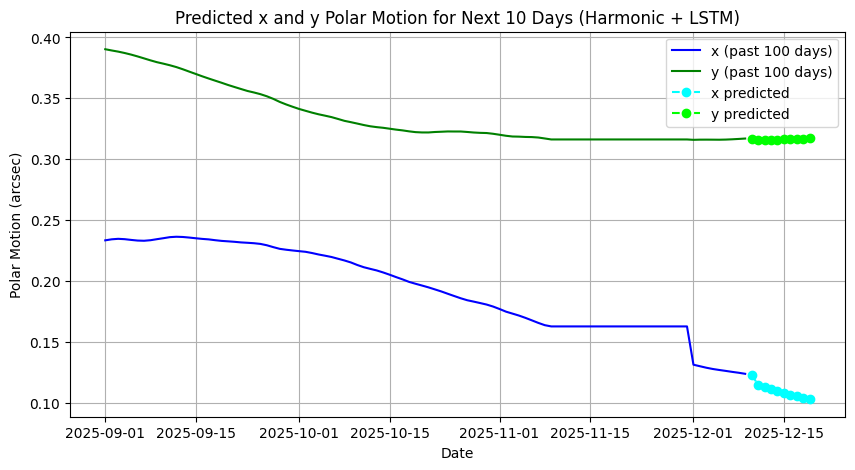

In [3]:
import requests
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import math

# =========================
# --- 1. دانلود و پردازش داده‌ها ---
# --- فایل C04 ---
url_c04 = "https://datacenter.iers.org/data/224/eopc04_14_IAU2000.62-now.txt"
resp = requests.get(url_c04, params={"downloadformat":"txt"})
with open("eop1.txt", "wb") as f: f.write(resp.content)

with open("eop1.txt", "r") as f:
    lines = f.readlines()[14:]  # حذف هدر
c04_data = []
for line in lines:
    try:
        parts = list(map(float, line.strip().split()))
        c04_data.append(parts)
    except:
        continue
c04_data = np.array(c04_data)[:, [3, 4, 5]]  # MJD, x, y

# --- فایل Bulletin ---
url_bu = "https://datacenter.iers.org/data/13/finals2000A.daily"
resp = requests.get(url_bu, params={"downloadformat":"txt"})
with open("bu.txt","wb") as f: f.write(resp.content)

with open("bu.txt","r") as f:
    lines = f.readlines()[14:]
bu_data = []
for line in lines:
    parts = line.strip().split()
    if len(parts)>=7:
        try:
            bu_data.append([float(parts[2]), float(parts[4]), float(parts[6])])  # MJD, x, y
        except:
            continue
bu_data = np.array(bu_data)

# --- ادغام داده‌ها ---
last_c04_mjd = c04_data[-1,0]
bu_new = bu_data[bu_data[:,0] > last_c04_mjd]
all_data = np.vstack([c04_data, bu_new])
print("Merged data shape:", all_data.shape)

# =========================
# --- 2. آماده‌سازی دیتاست ۵ ساله ---
today = datetime.utcnow()
start_date = today - timedelta(days=5*365)

def date_to_mjd(year, month, day):
    dt = datetime(year, month, day)
    a = (14 - dt.month)//12
    y = dt.year + 4800 - a
    m = dt.month + 12*a - 3
    jd = dt.day + ((153*m + 2)//5) + 365*y + y//4 - y//100 + y//400 - 32045
    mjd = jd - 2400000.5
    return mjd

mjd_start = date_to_mjd(start_date.year, start_date.month, start_date.day)
mjd_end = date_to_mjd(today.year, today.month, today.day)
mjd_range = np.arange(mjd_start, mjd_end+1, 1)

selected_data = []
for mjd in mjd_range:
    idx = np.where(all_data[:,0] <= mjd)[0]
    if len(idx)==0:
        continue
    selected_data.append(all_data[idx[-1]])
selected_data = np.array(selected_data)
print("Shape of 5-year dataset:", selected_data.shape)

# =========================
# --- 3. تبدیل به DataFrame ---
data = pd.DataFrame(selected_data[:,1:3], columns=['x','y'])
dates = pd.date_range(end=pd.Timestamp.utcnow().normalize(), periods=len(data))
data.index = dates

# =========================
# --- 4. Harmonic model با t0 = آخرین روز داده واقعی ---
def build_design_matrix(dates, periods, t0=None):
    if t0 is None:
        t0 = dates[0]
    tdays = (dates - t0).total_seconds() / 86400.0
    N = len(tdays)
    cols = [np.ones(N), tdays]
    for P in periods:
        omega = 2*math.pi/P
        cols.append(np.sin(omega*tdays))
        cols.append(np.cos(omega*tdays))
    return np.vstack(cols).T

periods = [365.25, 433.0, 365.25/2.0]
# طراحی harmonic روی داده واقعی
X_design = build_design_matrix(data.index, periods)
harmonic = pd.DataFrame(index=data.index, columns=['x','y'], dtype=float)
coefs = {}
for col in ['x','y']:
    beta, _, _, _ = np.linalg.lstsq(X_design, data[col].values, rcond=None)
    coefs[col] = beta
    harmonic[col] = X_design.dot(beta)

# residual
residuals = data - harmonic

# =========================
# --- 5. استانداردسازی residual ---
scaler = StandardScaler()
residuals_scaled = scaler.fit_transform(residuals.values)

# =========================
# --- 6. ساخت دنباله‌ها برای LSTM ---
look_back = 20
n_steps_out = 10
n_features = residuals_scaled.shape[1]

def create_sequences(data_scaled, look_back, n_steps_out):
    X, y = [], []
    for i in range(len(data_scaled) - look_back - n_steps_out + 1):
        X.append(data_scaled[i:i+look_back])
        y.append(data_scaled[i+look_back:i+look_back+n_steps_out])
    return np.array(X), np.array(y)

X, y = create_sequences(residuals_scaled, look_back, n_steps_out)
print("X shape:", X.shape, "y shape:", y.shape)

# =========================
# --- 7. تعریف مدل LSTM ---
model = Sequential([
    LSTM(16, activation='tanh', return_sequences=True, input_shape=(look_back, n_features)),
    Dropout(0.1),
    LSTM(8, activation='tanh'),
    Dense(n_steps_out * n_features)
])
model.compile(optimizer=Adam(0.001), loss='mae')

# =========================
# --- 8. آموزش مدل ---
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y.reshape(y.shape[0], -1), epochs=30, batch_size=32, callbacks=[early_stop], verbose=1)

# =========================
# --- 9. پیش‌بینی ۱۰ روز آینده ---
input_seq = residuals_scaled[-look_back:].copy()
pred_residuals_scaled = []

for day in range(n_steps_out):
    y_pred_full = model.predict(input_seq[np.newaxis,:,:], verbose=0)
    y_pred_full = y_pred_full.reshape(n_steps_out, n_features)
    y_pred_day = y_pred_full[0]
    pred_residuals_scaled.append(y_pred_day)
    input_seq = np.vstack([input_seq[1:], y_pred_day])

pred_residuals_scaled = np.array(pred_residuals_scaled)
pred_residuals = scaler.inverse_transform(pred_residuals_scaled)

# =========================
# --- 10. harmonic برای آینده با t0 = آخرین روز داده واقعی ---
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_steps_out, freq='D')
X_future = build_design_matrix(future_dates, periods, t0=data.index[0])
harmonic_future = pd.DataFrame(index=future_dates, columns=['x','y'], dtype=float)
for col in ['x','y']:
    harmonic_future[col] = X_future.dot(coefs[col])

# =========================
# --- 11. جمع residual + harmonic و اصلاح continuity ---
# offset correction برای اولین روز پیش‌بینی
first_offset = (data.iloc[-1].values - harmonic.iloc[-1].values - pred_residuals[0])
pred_residuals[0] += first_offset

pred_df = pd.DataFrame(pred_residuals, index=future_dates, columns=['x','y']) + harmonic_future

print("Predicted x and y for next 10 days:")
print(pred_df)

# =========================
# --- 12. رسم نمودار ---
plt.figure(figsize=(10,5))
plt.plot(data.index[-100:], data['x'][-100:], label='x (past 100 days)', color='blue')
plt.plot(data.index[-100:], data['y'][-100:], label='y (past 100 days)', color='green')
plt.plot(pred_df.index, pred_df['x'], 'o--', label='x predicted', color='cyan')
plt.plot(pred_df.index, pred_df['y'], 'o--', label='y predicted', color='lime')
plt.xlabel("Date")
plt.ylabel("Polar Motion (arcsec)")
plt.title("Predicted x and y Polar Motion for Next 10 Days (Harmonic + LSTM)")
plt.legend()
plt.grid(True)
plt.show()
